In [ ]:
import numpy as np
import jplus
import get_3dhst as hst
from astropy.io import fits
import elgtools as elg
import MockJPLUS as mtools
import matplotlib.pyplot as plt

# Loading J-PLUS data
print 'Loading J-PLUS'
mag_type = 'gpsfMags'
gal_jplus = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='idr', allphotoz=True, upperlimparams=True)


print 'Computing 3FM'
dm_min = 0.3 # rough number, to be computed as a function using the actual trumpet plots for individual tiles.

gal_jplus['dm'] = mtools.gen_3fm(gal_jplus['J0660'][:,0], gal_jplus['rJAVA'][:,0], 
                          gal_jplus['iJAVA'][:,0],Broad_NoLineName='iSDSS')

print 'setting redshift ranges of ELGs'
f_j0660 = jplus.datasets.fetch_jplus_filter('J0660') # Filter transmission curve

w_oii = 3727.0 # OII rest-frame
z_oii = elg.zline(w_oii, f_j0660.wave, f_j0660.throughput)

w_ha = 6563.0
z_ha = elg.zline(w_ha, f_j0660.wave, f_j0660.throughput)

w_hb = 4861.0
z_hb = elg.zline(w_hb, f_j0660.wave, f_j0660.throughput)

w_oiii = 5007.0
z_oiii = elg.zline(w_oiii, f_j0660.wave, f_j0660.throughput)

print z_oii, z_ha, z_hb, z_oiii

j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMags_idr_dual_magmax24.0.h5


Loading J-PLUS
Computing 3FM
setting redshift ranges of ELGs


In [2]:

print 'Loading 3D-HST and DEEP2'
# Loading 3D-HST and DEEP2 DR4 data

hstdata = hst.select_3DHST_z(0,5)#,LineName='Ha_flux',LineMin=0.001)
nhst = len(hstdata['ra'])
hst_coords = np.zeros([nhst,2])

for i in range(nhst):
    hst_coords[i,:] = [hstdata['ra'][i],hstdata['dec'][i]]
hstdata['coords'] = hst_coords

deep2_data = '/home/CEFCA/aaorsi/work/elg_jplus/spec/deep2/dr4/zcat.deep2.dr4.fits'
deep2 = fits.open(deep2_data)[1].data


# XMatch with 3DHST
print 'xmatch with 3DHST'
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],hstdata['coords'],max_distance=3e-3)
m = ((d != np.inf))

jhst0 = jplus.tools.select_object(gal_jplus, m)
jhst0['z_spec'] = hstdata['z'][ind[m]]

elg_hst =  ((jhst0['dm'] > dm_min) &
            (((jhst0['z_spec'] > z_ha[0])   & (jhst0['z_spec'] < z_ha[1]))   |
           ((jhst0['z_spec'] > z_hb[0])   & (jhst0['z_spec'] < z_hb[1]))   |
           ((jhst0['z_spec'] > z_oiii[0]) & (jhst0['z_spec'] < z_oiii[1])) |
           ((jhst0['z_spec'] > z_oii[0])  & (jhst0['z_spec'] < z_oii[1]))))

jhst = jplus.tools.select_object(jhst0, elg_hst)
nhst = len(jhst['z_spec'])
jhst['idd'] = np.arange(nhst)


# xmatch with DEEP2
print 'xmatch with DEEP2'
d2mask = ((deep2['ZQUALITY'] > 2) &  # Select only Deep2 objects with good quality Redshifts
        (deep2['Z'] <= z_ha[1]) |
           ((deep2['Z'] >= z_hb[0])   &   (deep2['Z'] <= z_hb[1]))   |
           ((deep2['Z'] >= z_oiii[0]) &   (deep2['Z'] <= z_oiii[1])) |
           ((deep2['Z'] >= z_oii[0])  &   (deep2['Z'] <= z_oii[1])))
          
          
ndeep2 = len(deep2['RA'][d2mask])
dcoords = np.asarray([[deep2['RA'][d2mask][i], deep2['DEC'][d2mask][i]] for i in range(ndeep2)])
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],dcoords,max_distance=3e-3)
m = ((d != np.inf))

jdeep2 = jplus.tools.select_object(gal_jplus, m & (gal_jplus['dm'] > dm_min))
jdeep2['z_spec'] = deep2['Z'][d2mask][ind[m & (gal_jplus['dm'] > dm_min)]]
ndeep2 = len(jdeep2['z_spec'])
#jdeep2['idd'] = np.arange(ndeep2)
print jdeep2['z_spec']
print 'Done loading data!'

Loading 3D-HST and DEEP2
xmatch with 3DHST
xmatch with DEEP2
[ 0.76511467  0.31466761  0.35483444  0.35719907  0.33090267  0.33462378
  0.7756151   0.75012684  0.37277409  0.33354449  0.31301913  0.35657647
  0.37176737  0.30759287  0.35438871  0.01540997  0.37501061  0.76541924
  0.76262033  0.30208999  0.75458628  0.32501391  0.76035857  0.75563228
  0.37058023  0.37706569  0.37163761  0.36804396  0.37415349  0.33301318
  0.32717979  0.32529244  0.75676161  0.35513747  0.77290154  0.35308605
  0.35725969  0.75106317  0.35549825  0.35093918  0.75080711  0.37285197
  0.35493267  0.78022605  0.76544303]
Done loading data!


In [3]:
print 'Reading and performing cross-match with ALHAMBRA objects'
import deepdish as dd
AlhambraFile = '/home/CEFCA/aaorsi/work/alhambra/Alhambra.hdf5'

alh = dd.io.load(AlhambraFile)
print alh.keys()


alh_d,alh_ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],alh['coords'],max_distance=3e-4)
alh_m = ((alh_d != np.inf))

j_alh = jplus.tools.select_object(gal_jplus, alh_m)
print 'Cross match between Alhambra and J-PLUS results in %ld objects' % len(j_alh['tile_id'])
j_alh['z_spec'] = alh['zphoto'][alh_ind[alh_m]]

plt.rcParams['figure.figsize'] = 5, 5

mask_elgs =  ((j_alh['dm'] > dm_min) &
            (((j_alh['z_spec'] > z_ha[0])   & (j_alh['z_spec'] < z_ha[1]))   |
           ((j_alh['z_spec'] > z_hb[0])   & (j_alh['z_spec'] < z_hb[1]))   |
           ((j_alh['z_spec'] > z_oiii[0]) & (j_alh['z_spec'] < z_oiii[1])) |
           ((j_alh['z_spec'] > z_oii[0])  & (j_alh['z_spec'] < z_oii[1]))))


plt.hist(j_alh['z_spec'][mask_elgs], bins=50)
nalh = len(j_alh['z_spec'][mask_elgs])

j_alhambra = jplus.tools.select_object(j_alh, mask_elgs)

print nalh





Reading and performing cross-match with ALHAMBRA objects
['F830W', 'F814W', 'F799W', 'F644W', 'F892W', 'F954W', 'F582W', 'zphoto', 'F427W', 'F675W', 'F551W', 'F768W', 'F365W', 'F706W', 'F458W', 'cstar', 'F489W', 'F861W', 'F923W', 'coords', 'F613W', 'F396W', 'F737W', 'F520W']
Cross match between Alhambra and J-PLUS results in 6415 objects
125


In [4]:
# Loading SDSS data

gal_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="galaxies")

print 'Cross-match of SDSS phot with J-PLUS ...'
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],gal_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))

j_spec = jplus.tools.select_object(gal_jplus, m)

        
print 'xmatch catalogue contains %ld galaxies' % len(j_spec['tile_id'])
        #jplus['in_sdss'] = m
        # Adding SDSS magnitudes
j_spec['rSDSS'] = gal_sdss_spec['rSDSS'][ind[m]]
j_spec['iSDSS'] = gal_sdss_spec['iSDSS'][ind[m]]
j_spec['uSDSS'] = gal_sdss_spec['uSDSS'][ind[m]]
j_spec['gSDSS'] = gal_sdss_spec['gSDSS'][ind[m]]
j_spec['zSDSS'] = gal_sdss_spec['zSDSS'][ind[m]]
j_spec['z_spec'] = gal_sdss_spec['zspec'][ind[m]]

plt.rcParams['figure.figsize'] = 5, 5

mask_elgs =  ((j_spec['dm'] > dm_min) &
            (((j_spec['z_spec'] > z_ha[0])   & (j_spec['z_spec'] < z_ha[1]))   |
           ((j_spec['z_spec'] > z_hb[0])   & (j_spec['z_spec'] < z_hb[1]))   |
           ((j_spec['z_spec'] > z_oiii[0]) & (j_spec['z_spec'] < z_oiii[1])) |
           ((j_spec['z_spec'] > z_oii[0])  & (j_spec['z_spec'] < z_oii[1]))))


plt.hist(j_spec['z_spec'][mask_elgs], bins=50)
nsdss = len(j_spec['z_spec'][mask_elgs])

j_sdss = jplus.tools.select_object(j_spec, mask_elgs)

print nsdss


j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_galaxies_aperMags_magmax21.0.h5


Cross-match of SDSS phot with J-PLUS ...
xmatch catalogue contains 88206 galaxies
347


In [5]:
%matplotlib inline
import matplotlib.gridspec as gsc

training_frac = 0.4 # the rest is for testing
ngals_tot = ndeep2 + nhst + nsdss + nalh
print 'Total number of galaxies used in training set: %d'%ngals_tot

dataspec = {}

for key in jdeep2:
    if key == 'date' or key == 'SQL_query' or key == 'filename':
        continue
    value_hst   = jhst[key]
    value_deep2 = jdeep2[key]
    value_sdss  = j_sdss[key]
    value_alh   = j_alhambra[key]
    shape = value_deep2.shape
    ndim = value_deep2.ndim
    dataspec[key] = np.zeros(ngals_tot) if ndim == 1 else np.zeros([ngals_tot, shape[1]])
    dataspec[key][0:ndeep2] = value_deep2
    dataspec[key][ndeep2:ndeep2+nhst] = value_hst   
    dataspec[key][ndeep2+nhst:ndeep2+nhst+nsdss] = value_sdss   
    dataspec[key][ndeep2+nhst+nsdss:] = value_alh   

dataspec['type'] = []
for i in range(ndeep2):
    dataspec['type'].append('DEEP2')
for i in range(nhst):
    dataspec['type'].append('3D-HST')
for i in range(nsdss):
    dataspec['type'].append('SDSS')
for i in range(nalh):
    dataspec['type'].append('Alhambra')
    
dataspec['index'] = np.arange(ndeep2 + nhst+nsdss+nalh)    





Total number of galaxies used in training set: 519


In [6]:
print 23**2

529


Number of xmatched ELGs: 519


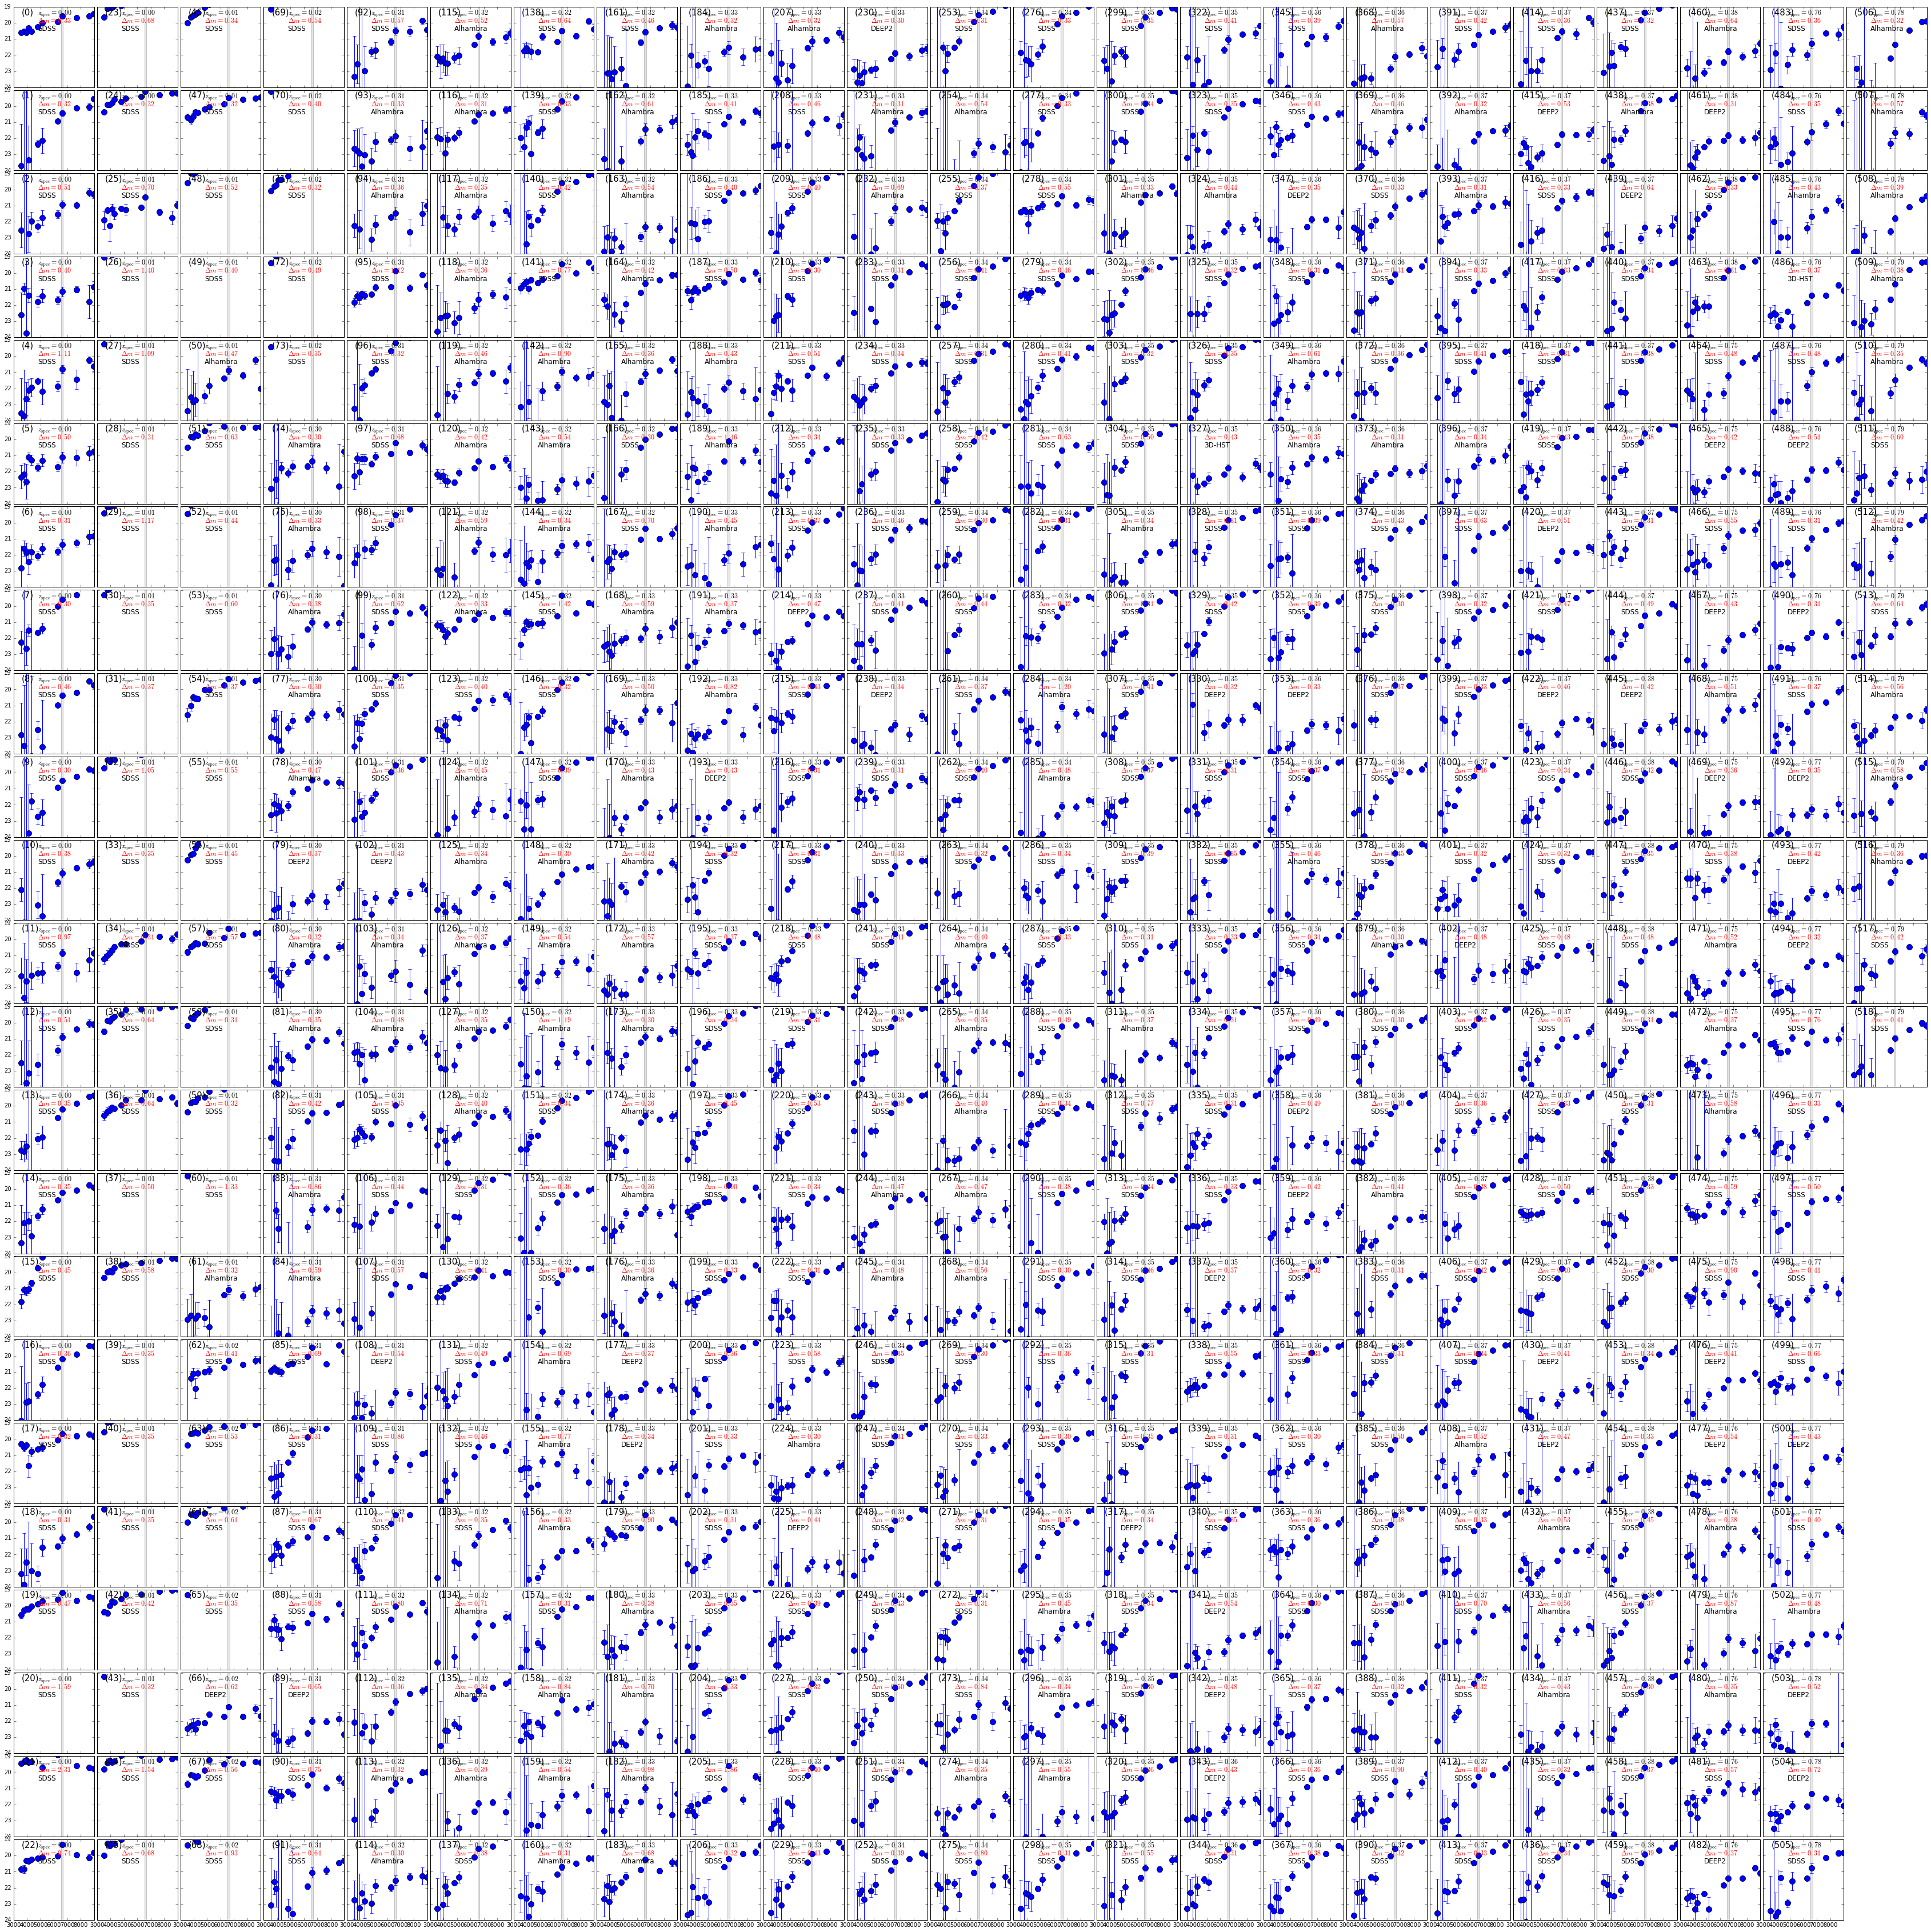

In [7]:
Plot_TrainingSet = True
import matplotlib.pyplot as plt

if Plot_TrainingSet:

    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
                #  'uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

    sdss_fnames = ['uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']
    sdss_mw     = [3543, 4770, 6231, 7625, 9134]

  
    grid = [23,23]
    gs = gsc.GridSpec(grid[0],grid[1])
    gs.update(wspace=0.035, hspace=0.035)

    plt.rcParams['figure.figsize'] = 60, 60

    
    nxm = len(dataspec['tile_id'])
    print 'Number of xmatched ELGs: %ld'%nxm
    dataspec['dm'] = mtools.gen_3fm(dataspec['J0660'][:,0], dataspec['rJAVA'][:,0], 
                              dataspec['iJAVA'][:,0],Broad_NoLineName='iSDSS')

    ix = 0
    iy = 0
    idg = 0

    sortz = np.argsort(dataspec['z_spec'])

    for i0 in range(nxm):
        i = sortz[i0]
        ax= plt.subplot(gs[ix,iy])
        idg = ix + grid[0]*iy
        for fname in filternames:
            filt = jplus.tools.fetch_jplus_filter(fname, quiet=True)
    #        print np.median(filt.wave)
            ww = [filt.avgwave(), filt.avgwave()]
            ff = [dataspec[fname][i,0], dataspec[fname][i,0]]

            ax.plot(ww,ff,'o', color='blue', markersize=10)
            ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='blue')


            if fname == 'J0660':# or fname == 'J0378' or fname == 'J0395' or fname=='J0861':
                fwidth = filt.rectwidth()
                ax.fill_between([ww[0] - fwidth/2.,ww[0] + fwidth/2.,ww[0] + fwidth/2.,ww[0] - fwidth/2.],
                            [19,19, 24, 24],facecolor='Grey',alpha=0.2)
        fw = 0   
        if sdss_fnames[0] in dataspec: # if sdss bands exist
            for fname in sdss_fnames:
                filt = jplus.tools.fetch_sdss_filter(fname, quiet=True)
    #        ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
                ww = [sdss_mw[fw], sdss_mw[fw]]
                fw += 1
                ff = [dataspec[fname][i,0], dataspec[fname][i,0]]
                ax.plot(ww,ff,'o', color='red', markersize=10)
                ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='red')

        ax.text(0.3,0.9,r'$z_{\rm spec}=%.2f$'%dataspec['z_spec'][i], transform= ax.transAxes, fontsize=12)
        ax.text(0.3,0.8,r'$\Delta m=%.2f$'%dataspec['dm'][i], transform= ax.transAxes, fontsize=12, color='red')
        ax.text(0.3,0.7,dataspec['type'][i], transform= ax.transAxes, fontsize=12, color='black')
        ax.text(0.1,0.9,'(%d)'%idg, transform=ax.transAxes,fontsize=15)
        ax.set_ylim([24, 18.99])
        ax.set_xlim([3000, 8999])
        if ix != grid[0]-1:
            ax.set_xticklabels([])
        if iy >0:
            ax.set_yticklabels([])
        ix +=1
        if ix == grid[0]:
            ix = 0
            iy += 1

    plt.show()        



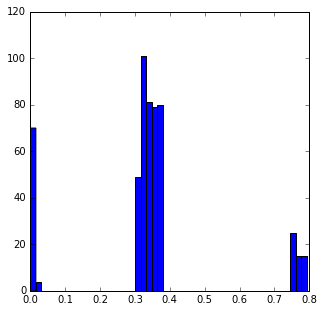

In [9]:
plt.rcParams['figure.figsize'] = 5, 5
plt.hist(dataspec['z_spec'],bins=50)
plt.show()

In [16]:
# Classifying the full set of galaxies
dataspec['class'] = []
for i in range(ngals_tot):
    zp = dataspec['z_spec'][i]
    if zp < z_ha[1]:
        dataspec['class'].append('Halpha')
    elif (zp > 0.25) and (zp < 0.45):
        dataspec['class'].append('Hbeta+OIII')
    elif (zp > 0.5):
        dataspec['class'].append('OII')
    else:
        print 'something is wrong with this redshift: %f'%zp

m_z0  = np.asarray(dataspec['class']) == 'Halpha'
m_zp3 = np.asarray(dataspec['class']) == 'Hbeta+OIII'
m_zp7 = np.asarray(dataspec['class']) == 'OII'

nz0  = len(dataspec['z_spec'][m_z0])
nzp3 = len(dataspec['z_spec'][m_zp3])  
nzp7 = len(dataspec['z_spec'][m_zp7])
print 'Number of Halpha emitters: %ld' % nz0
print 'Number of Hbeta + OIII emitters: %ld' % nzp3       
print 'Number of OII emitters: %ld' % nzp7


Number of Halpha emitters: 74
Number of Hbeta + OIII emitters: 390
Number of OII emitters: 55


In [31]:
# This function retrieves a features list for a single object.

def prepare_sample(data, index, sample_error = True, sample_type = 'All_Mags'):
    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
    
    flist = [] # filterslist
    nfilters = len(filternames)
    for ff in filternames:
        if sample_error:
            flist.append(np.random.normal(data[ff][index,0], data[ff][index,1])) # errors distribute like a gaussian (?)
        else:
            flist.append(data[ff][index,0])
    
    sample = [] # The sample's features
    
    # Here I should get creative
    if sample_type == 'All_Mags':
        sample = flist # All individual filters

    return sample

In [58]:
Training_set_class_frac = 0.7 # 50% of each class is used in the training set for validating
Sampling_errors         = 50  # Each training galaxy is resampled X times using its errors

# indices of different categories of objects
id_z0   = dataspec['index'][m_z0] 
id_z0p3 = dataspec['index'][m_zp3]
id_z0p7 = dataspec['index'][m_zp7]


# Randomised lists:
ran_idz0 = np.random.permutation(id_z0)
ran_idz0p3 = np.random.permutation(id_z0p3)    
ran_idz0p7 = np.random.permutation(id_z0p7)

id_arr = [ran_idz0, ran_idz0p3, ran_idz0p7]

training_features = []
training_class    = []

for id_obj in id_arr:
    nid = len(id_obj)
    print nid
    for i in range(int(nid*Training_set_class_frac)):
        for j in range(Sampling_errors):
            training_features.append(prepare_sample(dataspec, id_obj[i], sample_error=True, sample_type='All_Mags'))
            training_class.append(dataspec['class'][id_obj[i]])


validate_features = []
validate_class    = []

for id_obj in id_arr:
    nid = len(id_obj)
    print nid
    for i in range(int(nid*Training_set_class_frac), nid):
        validate_features.append(prepare_sample(dataspec, id_obj[i], sample_error=False, sample_type='All_Mags'))
        validate_class.append(dataspec['class'][id_obj[i]])



74
390
55
74
390
55


classif_rate for MLP: 100.000000
classif_rate for MLP: 100.000000
classif_rate for MLP: 100.000000
classif_rate for MLP: 100.000000
classif_rate for MLP: 100.000000
classif_rate for MLP: 100.000000


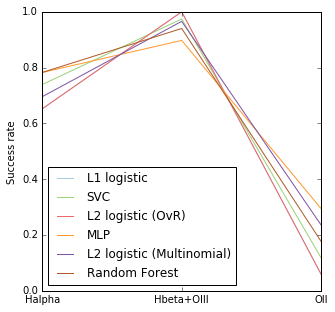

In [59]:
# Run ML
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn import tree
from sklearn import svm 

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF 

from sklearn.linear_model import LogisticRegression


Scaledata = True

if Scaledata:
    scaler = StandardScaler()
    scaler.fit(training_features)
    Traindata = scaler.transform(training_features)
    Testdata  = scaler.transform(validate_features)
    

#classifier = MLPClassifier(solver='lbfgs')
C = 1.0
kernel = 1.0 * RBF([1.0,1.0,1.0,1.0,1.0,1.0]) # for GPC

classifiers = { 'MLP'                       : MLPClassifier(solver='lbfgs'),
                    'Random Forest'             : RandomForestClassifier(n_estimators=10),
                    'SVC'                       : svm.SVC(),
                    'L1 logistic'               : LogisticRegression(C=C, penalty='l1'),
                    'L2 logistic (OvR)'         : LogisticRegression(C=C, penalty='l2'),
                    'L2 logistic (Multinomial)' : LogisticRegression(C=C, solver='lbfgs',multi_class='multinomial')
                    #'GPC'                       : GaussianProcessClassifier(kernel)
                    }

nclass = float(len(classifiers))
mlcolors = plt.cm.Paired(np.linspace(0,1,nclass))

plt.figure(2)
for index, (name, classifier) in enumerate(classifiers.items()):

    classifier.fit(Traindata, training_class)
    y_pred = classifier.predict(Testdata)
    classif_rate = np.mean(y_pred.ravel() == y_pred.ravel()) * 100.0
    print "classif_rate for %s: %f" % ('MLP', classif_rate)

    cnum = [0, 1, 2]
    ctype = ['Halpha', 'Hbeta+OIII', 'OII']

    real_val = np.zeros(len(y_pred))
    pred_val = np.zeros(len(y_pred))

    for i in range(len(y_pred)):
        if validate_class[i] == 'Halpha':
            real_val[i] = 0
        elif validate_class[i] == 'Hbeta+OIII':
            real_val[i] = 1
        elif validate_class[i] == 'OII':
            real_val[i] = 2

        if y_pred[i] == 'Halpha':
            pred_val[i] = 0
        elif y_pred[i] == 'Hbeta+OIII':
            pred_val[i] = 1
        elif y_pred[i] == 'OII':
            pred_val[i] = 2
            
    success_rate = np.zeros(3)

    for i in cnum:
        mm = np.where((real_val == i) & (real_val == pred_val))[0]
        success_rate[i] = np.float(len(mm)) / (len(np.where(real_val == i)[0]))
   
    plt.plot(cnum, success_rate,'-', label=name, color=mlcolors[index])
    plt.xticks(cnum, ctype)
    plt.ylabel('Success rate')
    plt.legend(loc='lower left')

classif_rate for MLP: 100.000000


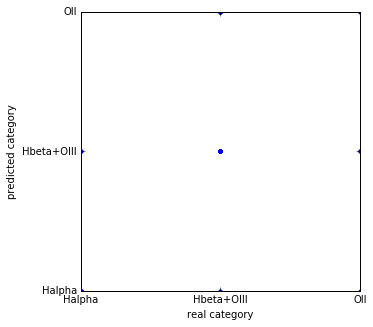

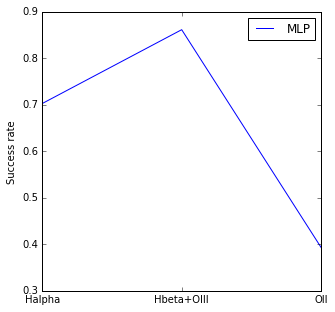